In [2]:
import os
import random
import numpy as np
import pandas as pd
import json
from PIL import Image
import pydicom
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
import timm
from tqdm import tqdm
import math
import SimpleITK as sitk

In [3]:
DATA_PATH = "/kaggle/input/rsna-2022-cervical-spine-fracture-detection"
train_df = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
test_df = pd.read_csv(os.path.join(DATA_PATH, "test.csv"))
sample_sub = pd.read_csv(os.path.join(DATA_PATH, "sample_submission.csv"))
TRAIN_IMG_DIR = os.path.join(DATA_PATH, "train_images")

study_ids = train_df["StudyInstanceUID"].unique()
np.random.seed(33)
np.random.shuffle(study_ids)
split_idx = int(len(study_ids) * 0.8)
train_studies = study_ids[:split_idx]
val_studies = study_ids[split_idx:]
train_df_split = train_df[train_df["StudyInstanceUID"].isin(train_studies)]
val_df_split = train_df[train_df["StudyInstanceUID"].isin(val_studies)]

In [6]:
class CervicalSliceDataset(Dataset):
    def __init__(self, df, root, transform=None, num_slices=5):
        self.df = df
        self.root = root
        self.transform = transform
        self.num_slices = num_slices
        self.study_ids = df["StudyInstanceUID"].unique().tolist()
    
    def __len__(self):
        return len(self.study_ids)
    
    def __getitem__(self, idx):
        study = self.study_ids[idx]
        folder = os.path.join(self.root, study)
        files = sorted([f for f in os.listdir(folder) if f.endswith(".dcm")])
        
        if len(files) == 0:
            raise RuntimeError(f"No DICOM in {folder}")
        
        indices = np.linspace(0, len(files)-1, self.num_slices, dtype=int)
        slices = []
        
        for i in indices:
            path = os.path.join(folder, files[i])
            ds = pydicom.dcmread(path)
            try:
                img = sitk.ReadImage(path)
                arr = sitk.GetArrayFromImage(img)[0]
            except Exception as e:
                print(f"⚠️ Error leyendo {path}: {e}")
                arr = np.zeros((512,512), dtype=np.float32)
            
            if arr.ndim == 3:
                arr = arr[0]
            
            img = Image.fromarray(arr).convert("L")
            if self.transform:
                img = self.transform(img)
            slices.append(img)
        
        img_tensor = torch.mean(torch.stack(slices), dim=0)
        
        row = self.df[self.df["StudyInstanceUID"]==study].iloc[0]
        label = torch.tensor([row["patient_overall"]], dtype=torch.float32)
        """
        for i in range(1,8):
            labels[i] = row[f"C{i}"]
        """
        return img_tensor, label



class CNN(nn.Module):
    def __init__(self, num_classes=8):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [8]:

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(0.3),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_ds = CervicalSliceDataset(train_df_split, TRAIN_IMG_DIR, transform=train_transforms, num_slices=5)
val_ds = CervicalSliceDataset(val_df_split, TRAIN_IMG_DIR, transform=val_transforms, num_slices=5)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=0, pin_memory=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando:", device)

model = CNN(num_classes=8).to(device)
criterion = nn.BCEWithLogitsLoss()   # Multi-etiqueta: C1–C7 + overall
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)



Usando: cuda


In [10]:
model = CNN(num_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [13]:
from torch.nn import functional as F

def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for imgs, labels in train_loader:
        # Asegura shape [B,1]
        if labels.ndim == 1:
            labels = labels.view(-1, 1)

        imgs  = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(imgs)                 # [B,1]
        loss   = criterion(logits, labels)   # BCEWithLogitsLoss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)


@torch.no_grad()
def evaluate(model, val_loader, criterion, device, threshold=0.5):
    model.eval()
    running_loss = 0.0
    acc_batches = 0.0
    n_batches = 0

    for imgs, labels in val_loader:
        if labels.ndim == 1:
            labels = labels.view(-1, 1)

        imgs   = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        logits = model(imgs)                  # [B,1]
        loss   = criterion(logits, labels)
        running_loss += loss.item()

        # accuracy binaria por batch
        probs = torch.sigmoid(logits)         # [B,1]
        preds = (probs > threshold).float()   # [B,1]
        acc   = (preds == (labels > 0.5)).float().mean().item()
        acc_batches += acc
        n_batches   += 1

    val_loss = running_loss / len(val_loader)
    val_acc  = acc_batches / max(1, n_batches)
    return val_loss, val_acc


In [14]:
train_losses, val_losses, val_accuracies = [], [], []

num_epochs = 10
for epoch in range(num_epochs):
    tr_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss, va_acc = evaluate(model, val_loader, criterion, device, threshold=0.5)

    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    val_accuracies.append(va_acc)

    print(f"Epoch {epoch+1:02d} | "
          f"Train loss: {tr_loss:.4f} | "
          f"Val loss: {va_loss:.4f} | "
          f"Val acc: {va_acc:.4f}")


Epoch 01 | Train loss: 0.6940 | Val loss: 0.6926 | Val acc: 0.4904
Epoch 02 | Train loss: 0.6924 | Val loss: 0.6948 | Val acc: 0.5240
Epoch 03 | Train loss: 0.6847 | Val loss: 0.7236 | Val acc: 0.5000
Epoch 04 | Train loss: 0.6885 | Val loss: 0.6940 | Val acc: 0.5288
Epoch 05 | Train loss: 0.6895 | Val loss: 0.6950 | Val acc: 0.5144
Epoch 06 | Train loss: 0.6886 | Val loss: 0.6931 | Val acc: 0.4976
Epoch 07 | Train loss: 0.6868 | Val loss: 0.6941 | Val acc: 0.5264
Epoch 08 | Train loss: 0.6867 | Val loss: 0.7012 | Val acc: 0.5433
Epoch 09 | Train loss: 0.6955 | Val loss: 0.6930 | Val acc: 0.5096
Epoch 10 | Train loss: 0.6877 | Val loss: 0.6924 | Val acc: 0.5361


In [15]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

@torch.no_grad()
def evaluate_full(model, loader, device, threshold=0.5):
    model.eval()
    all_labels, all_probs = [], []

    for imgs, labels in loader:
        if labels.ndim == 1:
            labels = labels.view(-1, 1)
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = model(imgs)
        probs = torch.sigmoid(logits).cpu().numpy().ravel()
        labels = labels.cpu().numpy().ravel()

        all_probs.extend(probs)
        all_labels.extend(labels)

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    preds = (all_probs > threshold).astype(int)

    # 🧮 métricas globales
    acc  = (preds == all_labels).mean()
    auc  = roc_auc_score(all_labels, all_probs)
    print(f"Accuracy: {acc:.3f} | AUC: {auc:.3f}")
    print(classification_report(all_labels, preds, digits=3))

    # 🧾 Matriz de confusión
    cm = confusion_matrix(all_labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Fx", "Fx"], yticklabels=["No Fx", "Fx"])
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.title("Matriz de confusión")
    plt.show()

    # 📈 Curva ROC
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1], [0,1], '--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curva ROC")
    plt.legend()
    plt.show()

    return acc, auc


Accuracy: 0.537 | AUC: 0.537
              precision    recall  f1-score   support

         0.0      0.570     0.391     0.464       207
         1.0      0.519     0.690     0.593       197

    accuracy                          0.537       404
   macro avg      0.545     0.541     0.528       404
weighted avg      0.545     0.537     0.527       404



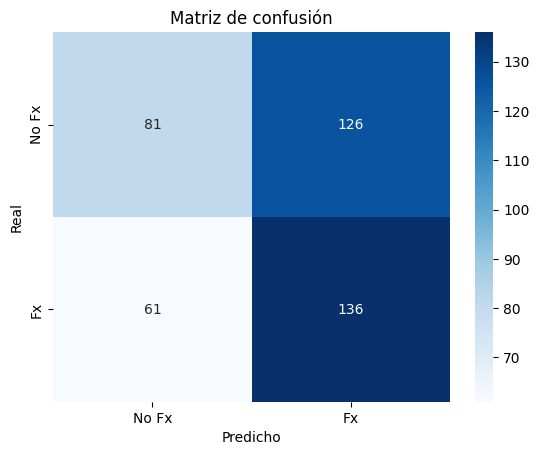

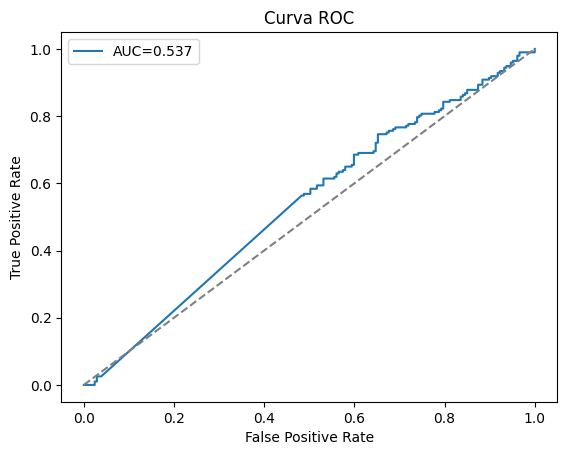

In [16]:
acc, auc = evaluate_full(model, val_loader, device)
